In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import warnings
from scipy import stats
from IPython.display import display
from sklearn import tree
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import graphviz
from sklearn.tree import export_graphviz
# warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
wine_df = pd.read_csv("wine.csv")
display(wine_df.columns)
wine_df.head(5)

Index(['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Mg',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Mg,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


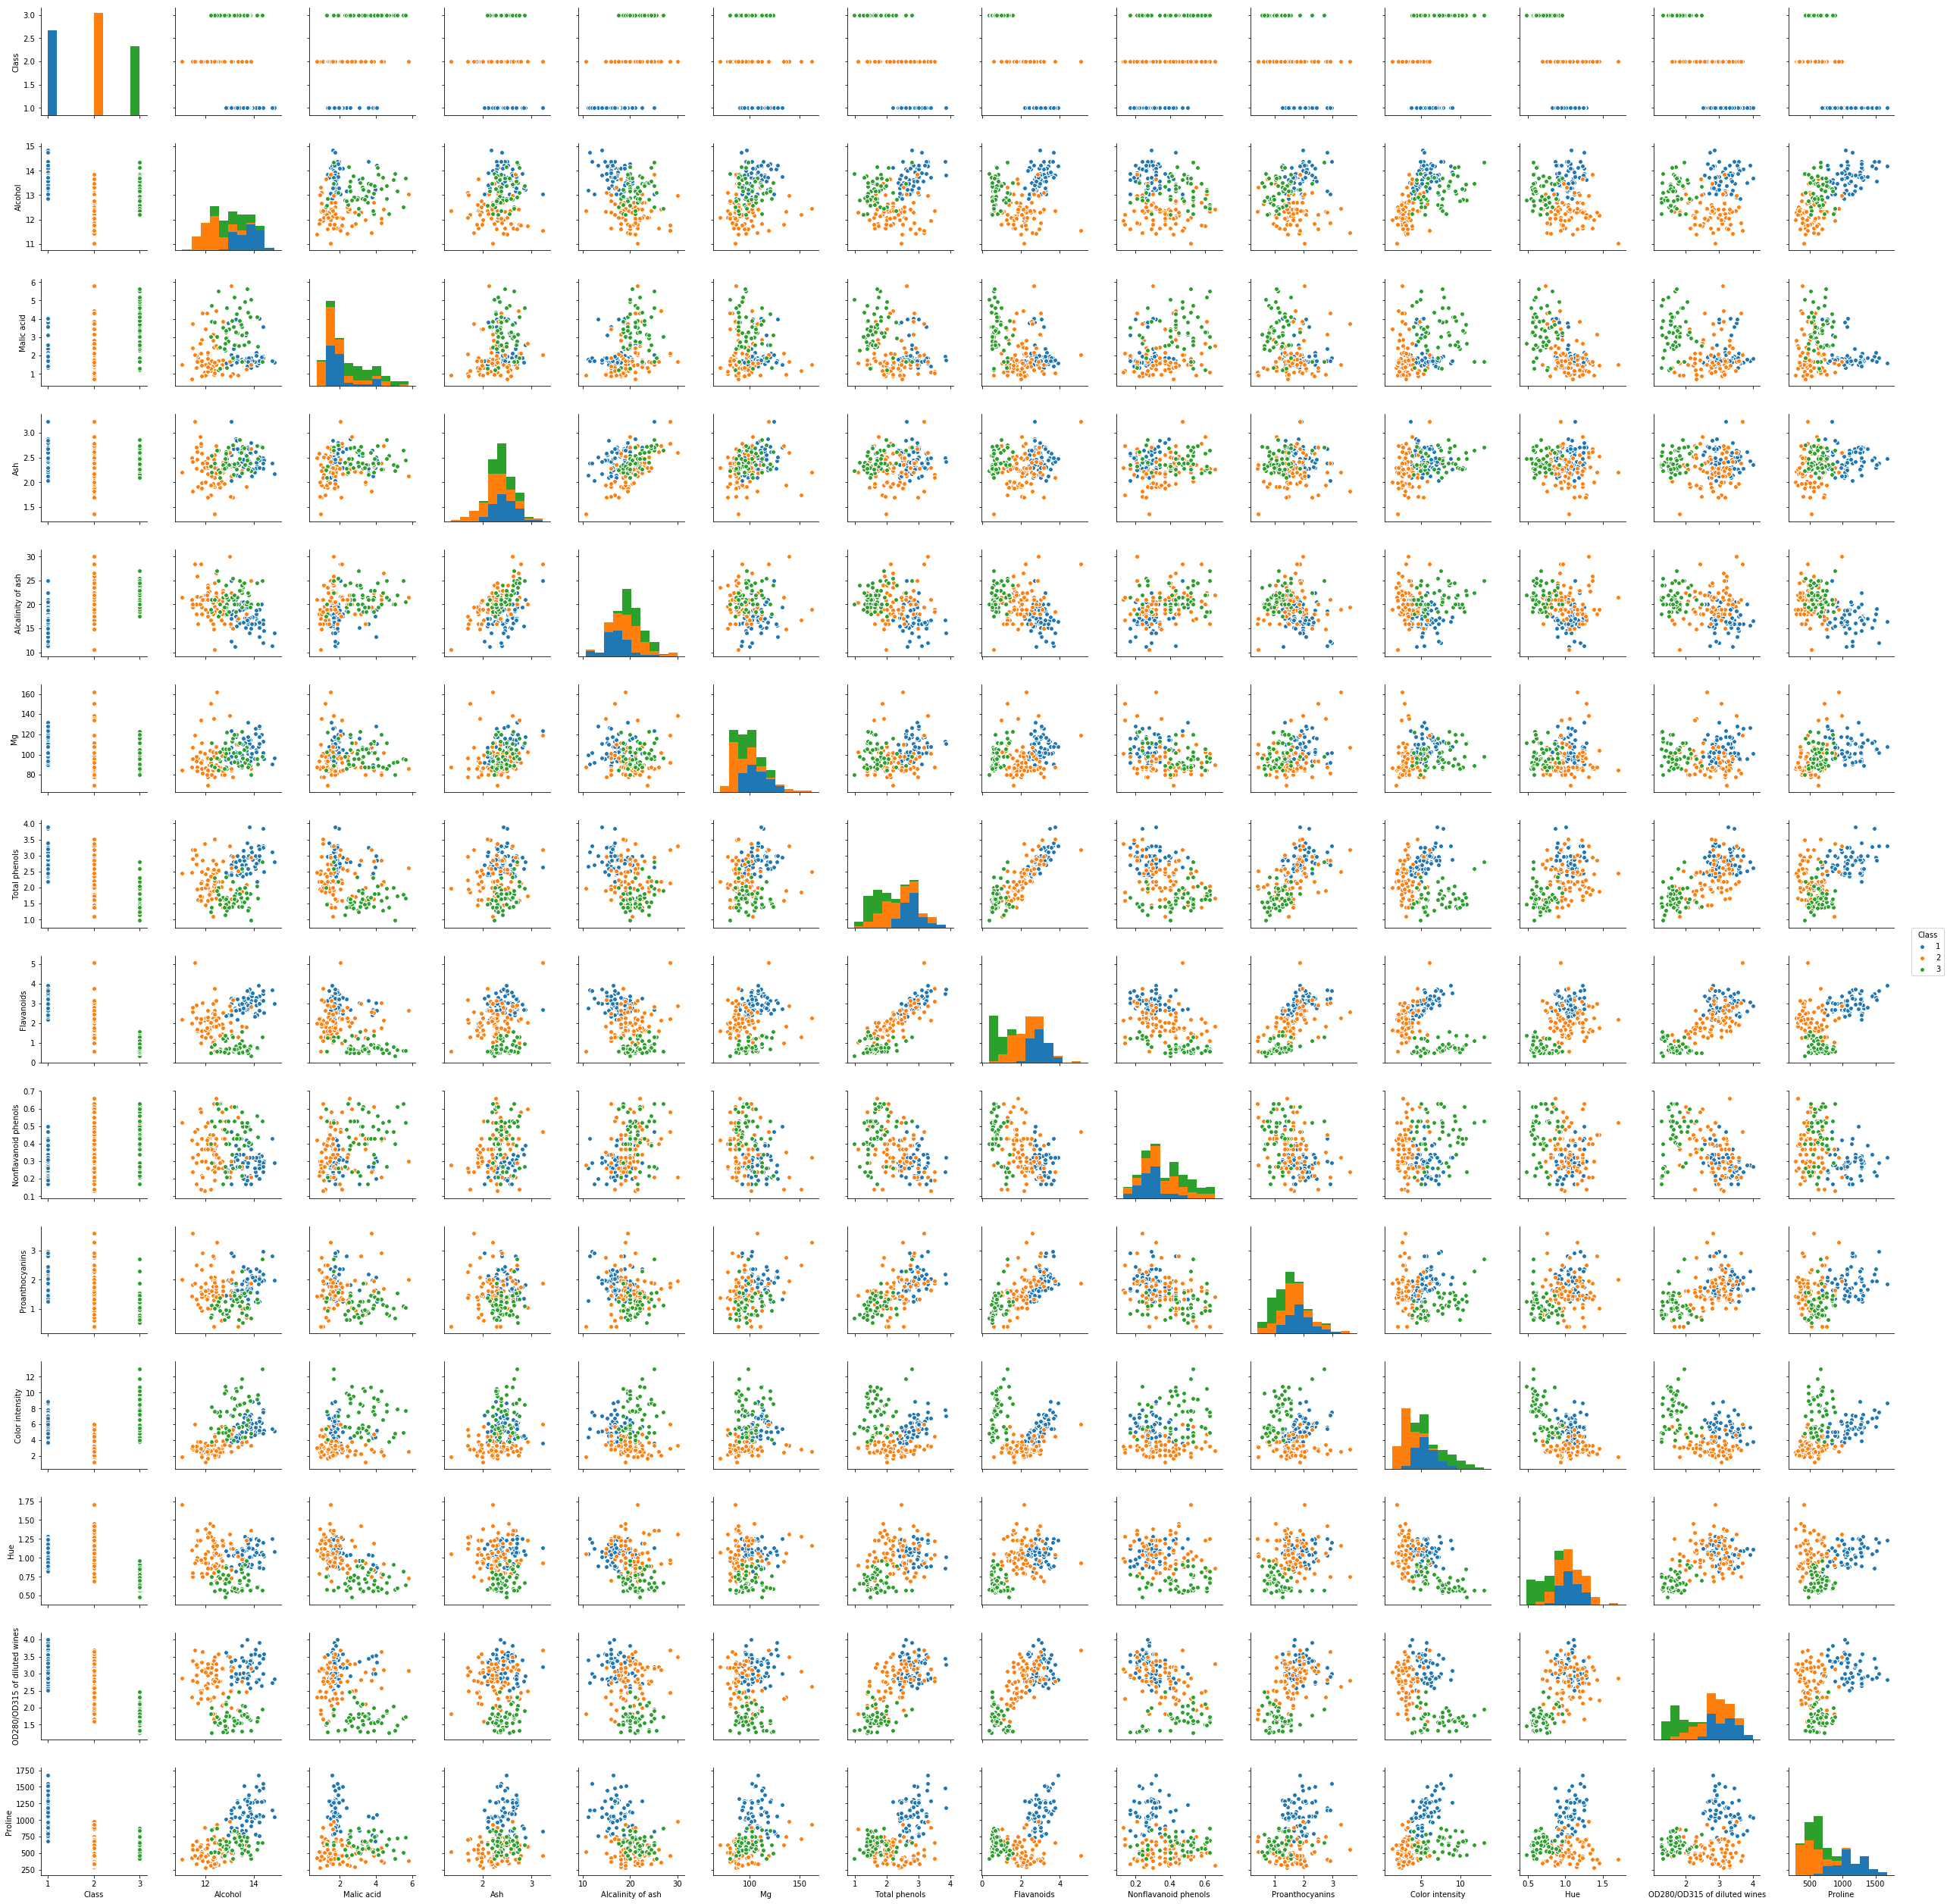

In [11]:
g = sns.pairplot(wine_df, hue='Class')

In [6]:
# This produces a rather attractive scatterplot 
# df:         a dataframe that contains featureA, featureB, and class_variable
# featureA:   a String representation of one of the columns in DF
# featureB:   a String representation of another of the columns in DF
# class_var:  a String representation of one the class labels column in DF
def feature_compare(df, featureA, featureB, class_var):
    g = sns.FacetGrid(data=df[[class_var, featureA, featureB]],hue=class_var,
                      hue_order=[1,2,3], aspect=1, size=5)
    fig = g.fig
    g.map(plt.scatter, featureA, featureB).add_legend()
    fig.suptitle(featureA + ' VS. ' + featureB)

## 1a: Plot of 'Randomly' Selected Variables

I have to confess, I didn't pick my variables randomly. As part of my regular exploratory routine, I made a pairs plot you see above and it was pretty obvious which features were separable. Just from inspection, 'OD280/OD315 of diluted wines' vs 'Proline' looks like it generates good, distinct clusters, but 'Alcohol' and 'Flavanoids" also looks fairly well clustered. But, to highlight the fact that some of these pairings are not useful for classification, I'll show a pairing that is poorly separable, like 'Ash' and 'Mg' (I shortened magnesium because the tabular representation of the wine dataframe (above) was just a bit too wide for this notebook).

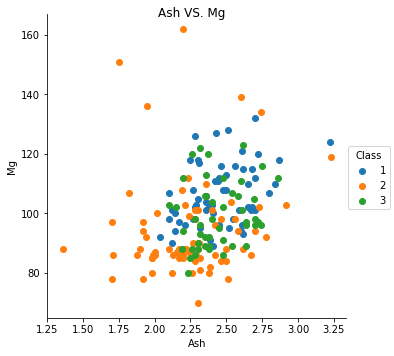

In [23]:
feature_compare(wine_df, 'Ash', 'Mg', 'Class')

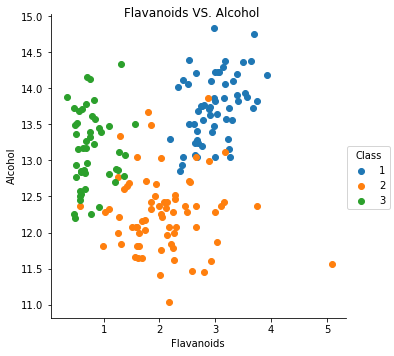

In [26]:
feature_compare(wine_df, 'Flavanoids', 'Alcohol',  'Class')

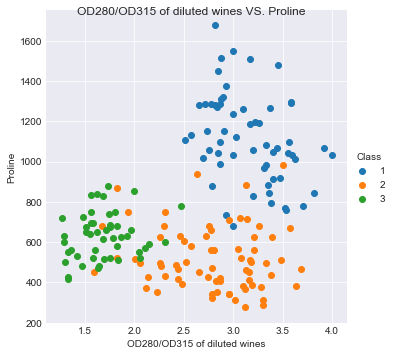

In [72]:
feature_compare(wine_df, 'OD280/OD315 of diluted wines', 'Proline', 'Class')

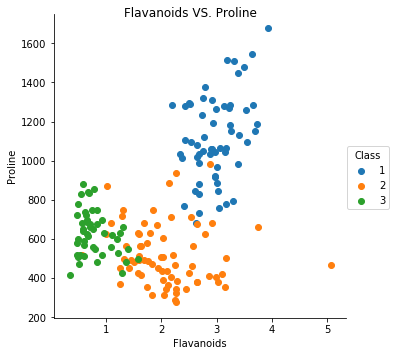

In [24]:
feature_compare(wine_df, 'Flavanoids', 'Proline', 'Class')

# 2: Classifiers!

## 2a: Decision Trees

In [7]:
wine_class_df = wine_df['Class']
wine_data_df = wine_df.drop('Class', axis=1)
wine_train, wine_test, class_train, class_test = train_test_split(wine_data_df,
                                                                  wine_class_df,
                                                                  test_size=0.34,
                                                                  random_state=123)

In [8]:
from sklearn import tree
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': list(range(1,10,2)),
    'min_samples_leaf': list(range(1,5,1)),
    'min_samples_split': list(range(2,10,1)),
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=1, cv=10, n_jobs=4)

In [12]:
%time _ = dt_clf_gs.fit(wine_train,class_train)

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=4)]: Done 222 tasks      | elapsed:    4.6s


Wall time: 7.45 s


[Parallel(n_jobs=4)]: Done 3200 out of 3200 | elapsed:    6.9s finished


({'criterion': 'entropy',
  'max_depth': 3,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'random_state': 123},
 0.90598290598290598)

** 2a.i: Decision Tree Parameters **

Using scikit-learn's GridSearchCV method, I tested multiple values for the [criterion, max depth, min # of samples per leaf, and min samples for a legal split] parameters. The greatest accuracy was achieved with [criterion = entropy, max depth = 3 nodes from root, min samples per leaf = 2 samples, and min samples before a a branch can split = 2.

From the tree produced by our singular (ie non-cross-validated) holdout partitioning, we see that the **Proline** attribute provides the clearest separating line between classes, decreasing entropy from $1.5365$ to $0.6891$ and $1.0074$ for **Proline** $> 755$ and **Proline** $<= 755$ respectively. As the largest descrease in entropy occurs relative to a node where **Flavanoids** provide the clearest separation,  this model suggests **Proline** and **Flavanoids** are the features with the most classifying power. 

In [14]:
wine_tree_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                            max_depth=3,
                                            min_samples_leaf=2,
                                            min_samples_split=2,
                                            random_state=123)
wine_tree_clf.fit(wine_train, class_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best')

In [15]:
export_graphviz(wine_tree_clf,out_file='wine_tree.dot', feature_names=wine_data_df.columns,
                rounded=True, rotate=True, filled=True,
                class_names=['Class 1', 'Class 2', 'Class 3'])

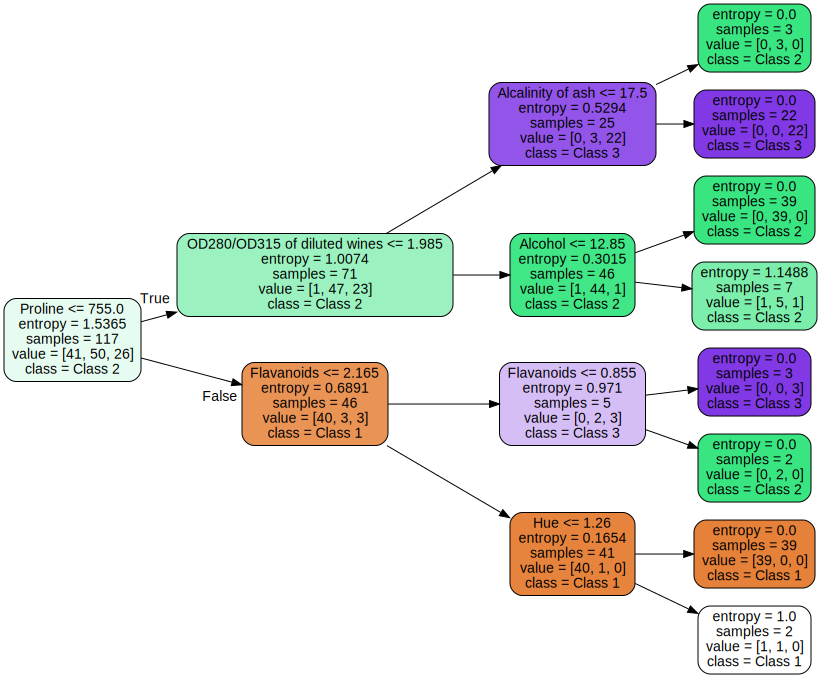

In [16]:
with open('wine_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [11]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like
        The data to fit. Can be, for example a list, or an array at least 2d.
    
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.
    
    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer 

In [17]:
dt_cv = cross_val_score(wine_tree_clf, wine_data_df, wine_class_df, cv=30)
dt_cv

array([ 0.85714286,  1.        ,  0.71428571,  0.85714286,  0.57142857,
        0.57142857,  1.        ,  1.        ,  1.        ,  1.        ,
        0.85714286,  1.        ,  0.83333333,  0.83333333,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.8       ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

In [18]:
print("Decision Tree Classifier accuracy on Training Set: {:0.3f}"
      .format(wine_tree_clf.score(wine_train, class_train)))
print("Decision Tree Classifier accuracy on Testing Set: {:0.3f}"
      .format(wine_tree_clf.score(wine_test, class_test)))
print("CV Classification Accuracy: {:0.3f} +/- {:0.3f})".format(dt_cv.mean(), dt_cv.std()))

Decision Tree Classifier accuracy on Training Set: 0.974
Decision Tree Classifier accuracy on Testing Set: 0.885
CV Classification Accuracy: 0.930 +/- 0.124)


** 2a.ii.1&2: Decision Tree Accuracy ** 
* **Training Data:** $0.974$
* **Testing Data:** $0.885$

There was a possibly significant difference between the accuracy of the model with the training and testing data, but that was just based off of 1 partitioning of the data. Decision trees are predisposed to overfitting, so we have to apply cross-validation to get a better estimate of accuracy. Using 30 folds, I obseved an accuracy of $0.930 \pm 0.124$ for this decision tree classifier.

** 2a.iii: Distributional Assumptions for Decision Trees **

Decision tree modeling makes no assumptions about the distribution. Independence between variables isn't necessary, variables can be categorical or continuous. 

## 2b: Naive Bayes

In [9]:
nb_gauss_clf = naive_bayes.GaussianNB()
nb_gauss_clf = nb_gauss_clf.fit(wine_train, class_train)
nb_gauss_preds = nb_gauss_clf.predict(wine_test)
accuracy_score(class_test, nb_gauss_preds)

nb_cv = cross_val_score(nb_gauss_clf, wine_data_df, wine_class_df, cv=30)

In [44]:
print("Naive Bayes Classifier accuracy on Training Set: {:0.3f}"
      .format(nb_gauss_clf.score(wine_train, class_train)))
print("Naive Bayes Classifier accuracy on Testing Set:  {:0.3f}"
      .format(nb_gauss_clf.score(wine_test, class_test)))
print("CrossValidated Naive Bayes Classifier Accuracy:  {:0.3f} +/- {:0.3f})"
      .format(nb_cv.mean(), nb_cv.std()))

Naive Bayes Classifier accuracy on Training Set: 0.983
Naive Bayes Classifier accuracy on Testing Set:  1.000
CrossValidated Naive Bayes Classifier Accuracy:  0.973 +/- 0.060)


In [14]:
nb_cv = cross_val_score(nb_gauss_clf, wine_data_df, wine_class_df, cv=30)
nb_cv

array([ 0.85714286,  1.        ,  1.        ,  0.85714286,  1.        ,
        1.        ,  1.        ,  1.        ,  0.85714286,  1.        ,
        1.        ,  1.        ,  0.83333333,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.8       ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

## 2c: KNN Classifier 

**2c.i:** KNN Classifier Accuracy

* **Training Data:** $1.000$
* **Testing Data:** $0.967$
* **30 fold, CV KNN:** $0.973 \pm 0.060$

**2c.ii:** Model Notes

For this KNN classifier, I used MinMax scaling on the data to 

In [51]:
def knn_classifier(k, data_df, class_df, weight='distance'):
    knn_clf = neighbors.KNeighborsClassifier(k, weights=weight)
    data_train, data_test, class_train, class_test = train_test_split(data_df,
                                                                  class_df,
                                                                  test_size=0.34,
                                                                  random_state=123)
    min_max_scaler = preprocessing.MinMaxScaler().fit(data_train)
    data_norm_train = min_max_scaler.transform(data_train)
    data_norm_test = min_max_scaler.transform(data_test)
    knn_clf.fit(data_norm_train, class_train)
    knn_pred = knn_clf.predict(data_norm_test)
    print("KNN Classifier accuracy (for k = {:0.0f}) on Training Set: {:0.3f}"
      .format(k, knn_clf.score(data_norm_train, class_train)))
    print("KNN Classifier accuracy (for k = {:0.0f}) on Testing Set: {:0.3f}"
      .format(k, knn_clf.score(data_norm_test, class_test)))

def knn_classifier_cv(k, data_df, class_df, weight='distance'):
    knn_clf = neighbors.KNeighborsClassifier(k, weights=weight)
    min_max_scaler = preprocessing.MinMaxScaler().fit(data_df)
    data_norm = min_max_scaler.transform(data_df)
    knn_cv = cross_val_score(knn_clf, data_norm, class_df, cv=30)
    print("CrossValidated KNN Classifier Accuracy (k = {:0.0f}): {:0.3f} +/- {:0.3f})"
      .format(k, knn_cv.mean(), knn_cv.std()))
    return knn_cv.mean(), knn_cv.std()

def knn_clf_k_finder(ks, data_df, class_df, weight='distance'):
    results = []
    stdevs = []
    for k in ks:
        k_mean, k_stdevs = knn_classifier_cv(k, data_df, class_df)
        results.append(k_mean)
        stdevs.append(k_stdevs)
    return results, stdevs
    
    

In [73]:
k_list = list(range(2,60,2))
res, stds = knn_clf_k_finder(k_list, wine_data_df, wine_class_df)

res

CrossValidated KNN Classifier Accuracy (k = 2): 0.951 +/- 0.085)
CrossValidated KNN Classifier Accuracy (k = 4): 0.953 +/- 0.090)
CrossValidated KNN Classifier Accuracy (k = 6): 0.954 +/- 0.088)
CrossValidated KNN Classifier Accuracy (k = 8): 0.949 +/- 0.090)
CrossValidated KNN Classifier Accuracy (k = 10): 0.958 +/- 0.079)
CrossValidated KNN Classifier Accuracy (k = 12): 0.959 +/- 0.078)
CrossValidated KNN Classifier Accuracy (k = 14): 0.973 +/- 0.060)
CrossValidated KNN Classifier Accuracy (k = 16): 0.973 +/- 0.060)
CrossValidated KNN Classifier Accuracy (k = 18): 0.969 +/- 0.063)
CrossValidated KNN Classifier Accuracy (k = 20): 0.973 +/- 0.060)
CrossValidated KNN Classifier Accuracy (k = 22): 0.973 +/- 0.060)
CrossValidated KNN Classifier Accuracy (k = 24): 0.978 +/- 0.056)
CrossValidated KNN Classifier Accuracy (k = 26): 0.978 +/- 0.056)
CrossValidated KNN Classifier Accuracy (k = 28): 0.969 +/- 0.073)
CrossValidated KNN Classifier Accuracy (k = 30): 0.969 +/- 0.073)
CrossValidated

[0.95063492063492072,
 0.95253968253968258,
 0.95444444444444443,
 0.94888888888888878,
 0.9584126984126986,
 0.95920634920634917,
 0.97349206349206352,
 0.97349206349206352,
 0.96873015873015877,
 0.97349206349206352,
 0.97349206349206352,
 0.97825396825396826,
 0.97825396825396826,
 0.96873015873015877,
 0.96873015873015877,
 0.96873015873015877,
 0.96873015873015877,
 0.96873015873015877,
 0.97349206349206352,
 0.97349206349206352,
 0.97349206349206352,
 0.97349206349206352,
 0.97349206349206352,
 0.97349206349206352,
 0.97349206349206352,
 0.97825396825396826,
 0.97825396825396826,
 0.96873015873015877,
 0.96317460317460324]

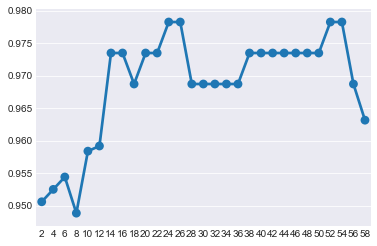

In [74]:
# sns.set_style("darkgrid")
# sns.axes_style("darkgrid")
ax = sns.pointplot(x=k_list, y=res)

In [27]:
knn_classifier(3, wine_data_df, wine_class_df, weight='distance')
knn_classifier_cv(3, wine_data_df, wine_class_df)

KNN Classifier accuracy (for k = 3) on Training Set: 1.000
KNN Classifier accuracy (for k = 3) on Testing Set: 0.967
CrossValidated KNN Classifier Accuracy: 0.957 +/- 0.081)


(0.95730158730158743, 0.080816724182147984)

In [33]:
gammas = sns.load_dataset("gammas")

In [36]:
gammas.head(5)

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992


In [46]:
# help(sns.pointplot)
help(range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |

In [30]:
knn_classifier(2, wine_data_df, wine_class_df, weight='distance')
knn_classifier_cv(2, wine_data_df, wine_class_df)

KNN Classifier accuracy (for k = 2) on Training Set: 1.000
KNN Classifier accuracy (for k = 2) on Testing Set: 0.984
CrossValidated KNN Classifier Accuracy: 0.951 +/- 0.085)


(0.95063492063492072, 0.085152331894729136)

In [31]:
knn_classifier(40, wine_data_df, wine_class_df, weight='distance')
knn_classifier_cv(40, wine_data_df, wine_class_df)

KNN Classifier accuracy (for k = 40) on Training Set: 1.000
KNN Classifier accuracy (for k = 40) on Testing Set: 0.951
CrossValidated KNN Classifier Accuracy: 0.973 +/- 0.060)


(0.97349206349206352, 0.059978370166928328)

In [32]:
knn_classifier(1, wine_data_df, wine_class_df, weight='distance')
knn_classifier_cv(1, wine_data_df, wine_class_df)

KNN Classifier accuracy (for k = 1) on Training Set: 1.000
KNN Classifier accuracy (for k = 1) on Testing Set: 0.984
CrossValidated KNN Classifier Accuracy: 0.951 +/- 0.085)


(0.95063492063492072, 0.085152331894729136)

In [13]:
wine_data_df.columns

Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Mg',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

In [16]:
wine_data_df[['Alcohol','Ash']]

def knn_feat_compare(data_df, class_df):
    results = pd.DataFrame
    
    for featA in data_df.columns

,Alcohol,Ash
0,14.23,2.43
1,13.20,2.14
2,13.16,2.67
3,14.37,2.50
4,13.24,2.87
5,14.20,2.45
6,14.39,2.45
7,14.06,2.61
8,14.83,2.17
9,13.86,2.27


# 3: Basic Concepts

## 3.1: Training Error

When making a classifier, we are trying to make a model that we can apply to data that wasn't used in building the model. We can add parameters to our classifier so that we correctly classify every data point (ie we can overfit the model), but if that doesn't improve our ability to classify new data, then it's not valuable. We want to build a classifier that performs best (ie has the lowest prediction error) with data that wasn't used to build the classifier.  

## 3.2: Collective Relevance 

As the picture showing the chessboard problem demonstrates, the data's projection onto either axes, $x_1$ or $x_2$, appears to show the data points are randomly distributed and well mixed, but from visual inspection, there are obvious well-defined clusters separated by class. If the classes weren't recognized, features $x_1$ or $x_2$ would appear to be uncorrelated and independent, and that's clearly not correct. 

## 3.3: Irrelevant features

As picture 5 shows, the green triangles and red circles are similarly distributed along the horizontal axis (on the right side of the picture) and this would lead to a KNN classifier incorrectly classifying many of the data points. Performing LDA on this data clearly reveals the optimal axes orientation for this data (shown on the left side) which eliminates the unnecessary axis. This is also an example of the "Curse of Dimensionality".

## 3.4: Occam's Razor

The picture with the Occam's razor caption doesn't quite fit with the understanding of Occam's razor I gained in my physics education. The forumlation I learned basically says that, when comparing multiple possible explanations for some observed phenomena (after eliminating the theories that are contradicted by the observed data), prefer the simplest theory until new data forces you to add complexity.

I guess I could relate it to the image by saying that the simplest model (which would survive Occam's razor) will only try to explain the data that has been seen and won't include features that expand the domain to unseen data.